# MLCV Assignment: Semantic Segmentation of Unexpected Objects on Roads

*   **Student ID:** 0001111416
*   **Full Name:** Alessio Pittiglio
*   **Institutional Email:** alessio.pittiglio@studio.unibo.it

## 1. Introduction

This project addresses the task of **semantic segmentation of unexpected objects on roads**, more generally known in the literature as *open-set semantic segmentation*, *open-world semantic segmentation*, or *anomaly segmentation*.

Traditional semantic segmentation methods often fail to detect objects that were not seen during training (e.g., a cat on the road misclassified as asphalt). This limitation poses significant challenges for safety-critical applications such as autonomous driving.

The goal of this project is to develop and evaluate a model capable of segmenting 12 known classes from the StreetHazards dataset (`building`, `fence`, `other`, `pedestrian`, `pole`, `road line`, `road`, `sidewalk`, `vegetation`, `car`, `wall`, `traffic sign`) and additionally identifying anomalous objects that appear only in the test set.

This notebook will guide you through the setup, data loading, evaluation of the chosen approach, qualitative analysis of the results and the ablation study. 

## 2. Setup and Configuration

First, we import the necessary libraries and set the random seeds for reproducibility. We also import the custom modules implemented for this project (`datamodule.py`, `model_residual`, `model_uncertainty.py`, etc.).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torchinfo import summary
from torchvision.datasets import VOCSegmentation
from torchvision.transforms import v2

import lightning as L

import mlcv_openset_segmentation.postprocessing as pp
from mlcv_openset_segmentation.benchmark import compute_gflops, measure_inference_time
from mlcv_openset_segmentation.datasets.datamodule import (
    StreetHazardsDataModule,
    StreetHazardsOEDataModule,
)
from mlcv_openset_segmentation.models.model_uncertainty import (
    UncertaintyModel,
    ANOMALY_ID,
)

from mlcv_openset_segmentation.models.model_residual import ResidualPatternLearningModel
from mlcv_openset_segmentation.models.model_metric import MetricLearningModel
from mlcv_openset_segmentation.postprocessing import BoundarySuppressionWithSmoothing
from mlcv_openset_segmentation.utils import (
    create_statistics_plots,
    plot_runs_dual_axis,
    unnormalize_image,
    visualize_mask,
    collect_representative_samples,
    load_or_compute_per_class_iou,
    visualize_samples_per_class,
    load_or_compute_frequencies,
    plot_class_distribution,
    plot_runs,
    plot_metrics_dual_axis,
    get_best_metric,
)

In [2]:
torch.set_float32_matmul_precision("high")
L.seed_everything(42, workers=True)

Seed set to 42


42

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We define the hyperparameters used in the project.

In [4]:
data_dir = Path("data")
batch_size = 8
num_classes = 13

image_height = 720
image_width = 1280

image_mean = [0.485, 0.456, 0.406]
image_std = [0.229, 0.224, 0.225]

checkpoint_path_seg = Path("checkpoints/phase1_best_segmenter.ckpt")
checkpoint_path_rpl = Path("checkpoints/phase2_best_rpl.ckpt")
train_stats_path = Path("stats/train_class_distribution.csv")
val_stats_path = Path("stats/val_class_distribution.csv")
full_stat_path = Path("stats/full_stats.pt")
test_metrics_path = Path("stats/test_metrics.csv")

class_names = [
    "unlabeled",
    "building",
    "fence",
    "other",
    "pedestrian",
    "pole",
    "road line",
    "road",
    "sidewalk",
    "vegetation",
    "car",
    "wall",
    "traffic sign",
]

`num_classes` is set to 13, including the 12 known classes mentioned in the introduction plus the unlabeled class, which represents background or undefined regions.

## 3. Methodology

### 3.1 Approach Overview

We adopt the approach proposed by Liu et al. [5]. In their work, a residual pattern learning (RPL) module is introduced and added on top of a frozen segmentation network. This module is trained to learn the residual patterns of anomalies based on intermediate features. The authors use DeepLabV3+ pre-trained on the Cityscapes dataset, to which the RPL module is attached. The module is trained using Outlier Exposure (OE), which involves pasting objects from the COCO dataset (outliers) onto images from the Cityscapes dataset (inliers). In our case, StreetHazards serves as the inlier dataset. 

Our pipeline is divided into two phases:

1. A segmentation network is trained to recognize the known classes in the StreetHazards dataset, using DeepLabV3+ with a ResNet-50 backbone.
2. The RPL module is added on top of the frozen segmentation model and trained with Outlier Exposure. We use Pascal VOC as an outlier dataset.

During the implementation of the RPL module, we observed training instabilities due to the vanishing gradient problem inherent in the original loss formulation. To address this issue, we adopted the energy-entropy learning loss proposed by Xia et al. [6], which replaces the ReLU activation with a sigmoid-based mapping.

### 3.2 Metrics

Performance is evaluated according to the metrics specified in the assignment guidelines. mIoU is computed over the 12 known classes for the closed-set semantic segmentation task using TorchMetrics' JaccardIndex, while AUPR for anomaly segmentation is computed using scikit-learn's `average_precision_score`.

## 4. Data Loading and Preparation

### 4.1 Implementation Details

For dataset loading and preprocessing, we implemented the `StreetHazardsDataModule` using PyTorch Lightning. This module encapsulates the `StreetHazardsDataset` class, which parses the `.odgt` files and constructs DataLoader instances for the training, validation, and test sets. Next, transformations are applied to the images. To this end, we use the recent `torchvision.transforms.v2` API, which allows geometric transformations to be applied consistently to both the image and the mask. Finally, the images are normalized using the ImageNet mean and standard deviation, as the model's backbone is pre-trained on this dataset.

In [5]:
train_transform = v2.Compose(
    [
        v2.Resize(
            (image_height, image_width), interpolation=v2.InterpolationMode.BILINEAR
        ),
        v2.RandomHorizontalFlip(p=0.5),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=image_mean, std=image_std),
    ]
)

eval_transform = v2.Compose(
    [
        v2.Resize(
            (image_height, image_width), interpolation=v2.InterpolationMode.BILINEAR
        ),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=image_mean, std=image_std),
    ]
)

In [6]:
data_module = StreetHazardsDataModule(
    root_dir=data_dir,
    batch_size=batch_size,
    num_workers=0,
    train_transform=train_transform,
    eval_transform=eval_transform,
)
data_module.setup()

In [7]:
train_loader = data_module.train_dataloader()
val_loader = data_module.val_dataloader()

The `StreetHazardsOEDataModule` class includes several additional parameters, such as `inject_probability`, which controls the probability of inserting an anomaly into the image, and `max_anomalies_per_image` which specifies the maximum number of anomalies added per image. The `anomaly_normalize` parameter ensures that anomalies are normalized using the same mean and standard deviation as the inlier dataset.

In [8]:
normalize_only = v2.Normalize(mean=image_mean, std=image_std)

In [9]:
voc_train = VOCSegmentation(
    root="data/VOC",
    year="2012",
    image_set="train",
    download=False,
)

voc_val = VOCSegmentation(
    root="data/VOC",
    year="2012",
    image_set="val",
    download=False,
)

oe_data_module = StreetHazardsOEDataModule(
    root_dir=data_dir,
    outlier_train_dataset=voc_train,
    outlier_val_dataset=voc_val,
    batch_size=batch_size,
    num_workers=0,
    train_transform=train_transform,
    eval_transform=eval_transform,
    anomaly_normalize=normalize_only,
    inject_probability=0.5,
    max_anomalies_per_image=3,
)
oe_data_module.setup()

In [10]:
oe_train_loader = oe_data_module.train_dataloader()
oe_val_loader = oe_data_module.val_dataloader()
oe_test_loader = oe_data_module.test_dataloader()

Since StreetHazards does not provide a validation set containing anomalies, no direct proxy exists for evaluating the model's anomaly detection capability during training. Consequently, we adopt the following strategy.

1. **Phase 1:** the model is trained on the StreetHazards training set and validated on the StreetHazards validation set, which is used to compute the mIoU for semantic segmentation. At the end of this phase, the model is not evaluated on the official test set; instead, it is assessed on a modified version of the validation set in which anomalies are injected. This enables model selection based on both mIoU and AUPR.

2. **Phase 2:** the RPL module is trained on the training set using Outlier Exposure. Validation is performed on the same modified dataset used in Phase 1, and AUPR is monitored throughout training. Finally, the best-performing model is evaluated on the StreetHazards test set.

### 4.2 Exploratory Data Analysis (EDA) 

First, we analyze the composition of the dataset.

In [11]:
print("Training set size:", len(train_loader.dataset))
print("Validation set size:", len(val_loader.dataset))
print("Test set size:", len(oe_test_loader.dataset))

Training set size: 5125
Validation set size: 1031
Test set size: 1500


Let's visualize an example from the test set along with its corresponding ground-truth segmentation mask.

In [12]:
raw_to_target = oe_test_loader.dataset.raw_to_target
target_to_raw = {v: k for k, v in raw_to_target.items()}

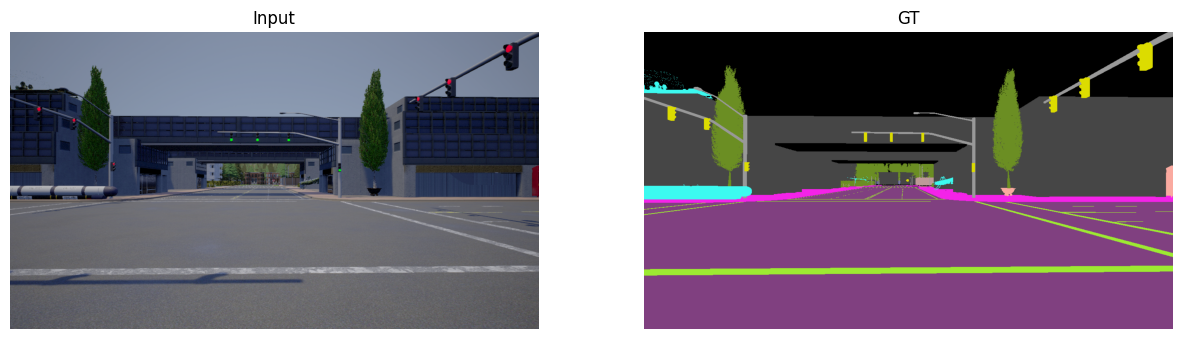

In [13]:
batch = next(iter(oe_test_loader))
images, masks = batch

images = unnormalize_image(images, image_mean, image_std)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.imshow(images[0].permute(1, 2, 0))
plt.title("Input")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(visualize_mask(masks[0]))
plt.title("GT")
plt.axis("off")
plt.show()

Below, we show a representative example for each class.

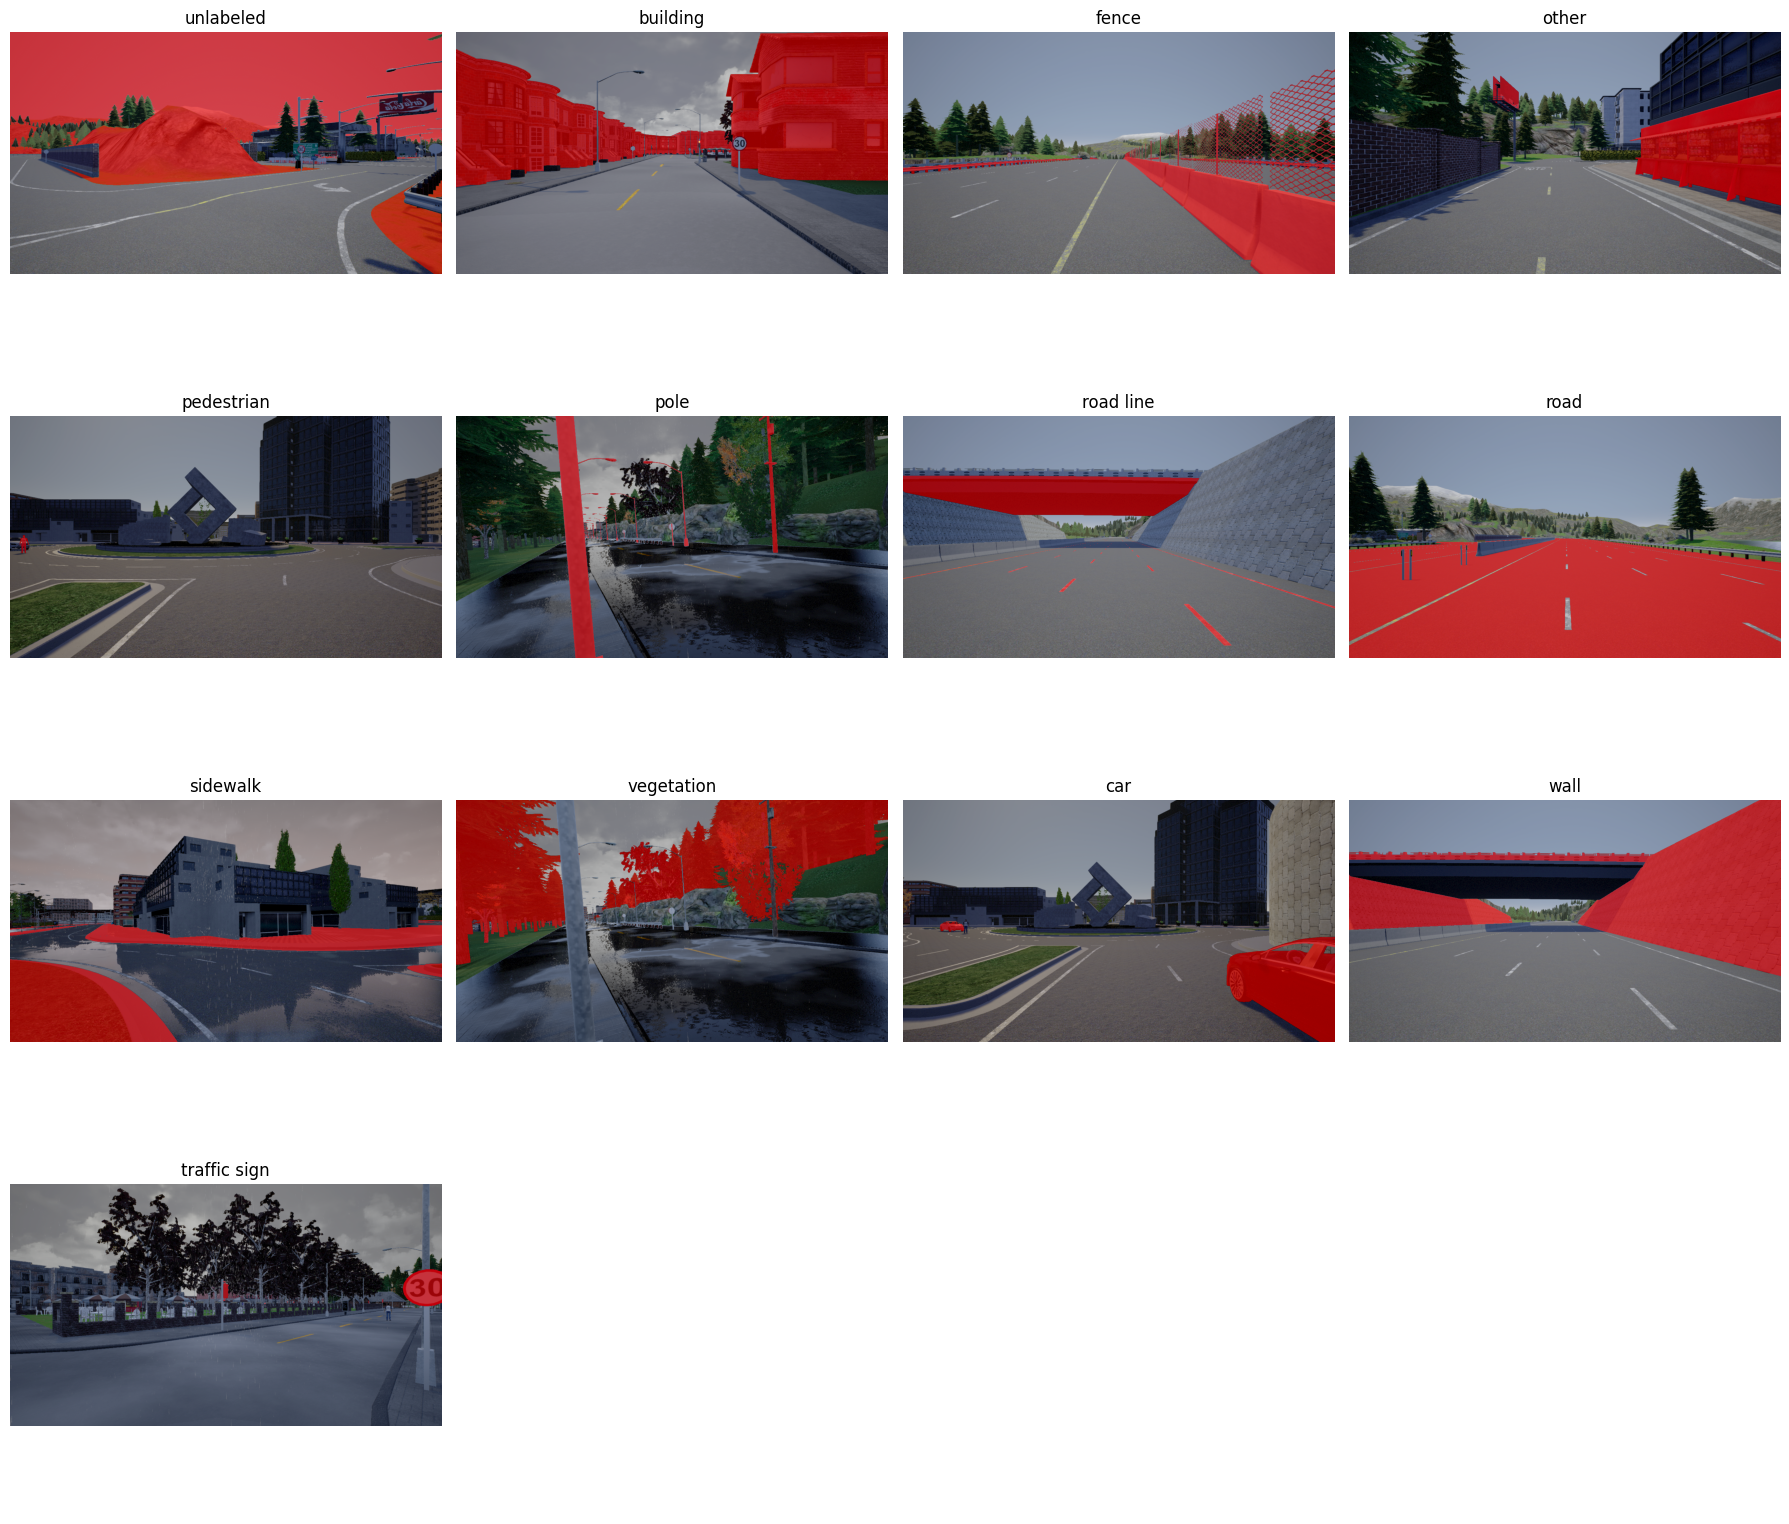

In [14]:
samples_per_class = collect_representative_samples(
    dataloader=train_loader,
    num_classes=num_classes,
    max_batches=5,
)

visualize_samples_per_class(
    samples=samples_per_class,
    class_names=class_names,
    image_mean=image_mean,
    image_std=image_std,
)

Two observations can be made: 

1. Some images contain very small objects that are nearly imperceptible, even when zoomed in, yet are still labelled. This suggests that the model may struggle to accurately segment such objects. 
2. Another important consideration concerns the classes `unlabeled` and `other`. A visual analysis shows that `unlabeled` is used to represent the background, which mostly corresponds to the sky. However, there are instances where other elements are included in the background. The class `other` also appears to represent several different objects. Therefore, this may introduce ambiguity and misclassifications that can affect the final results.

Finally, we analyze the distribution of pixels across the different classes.

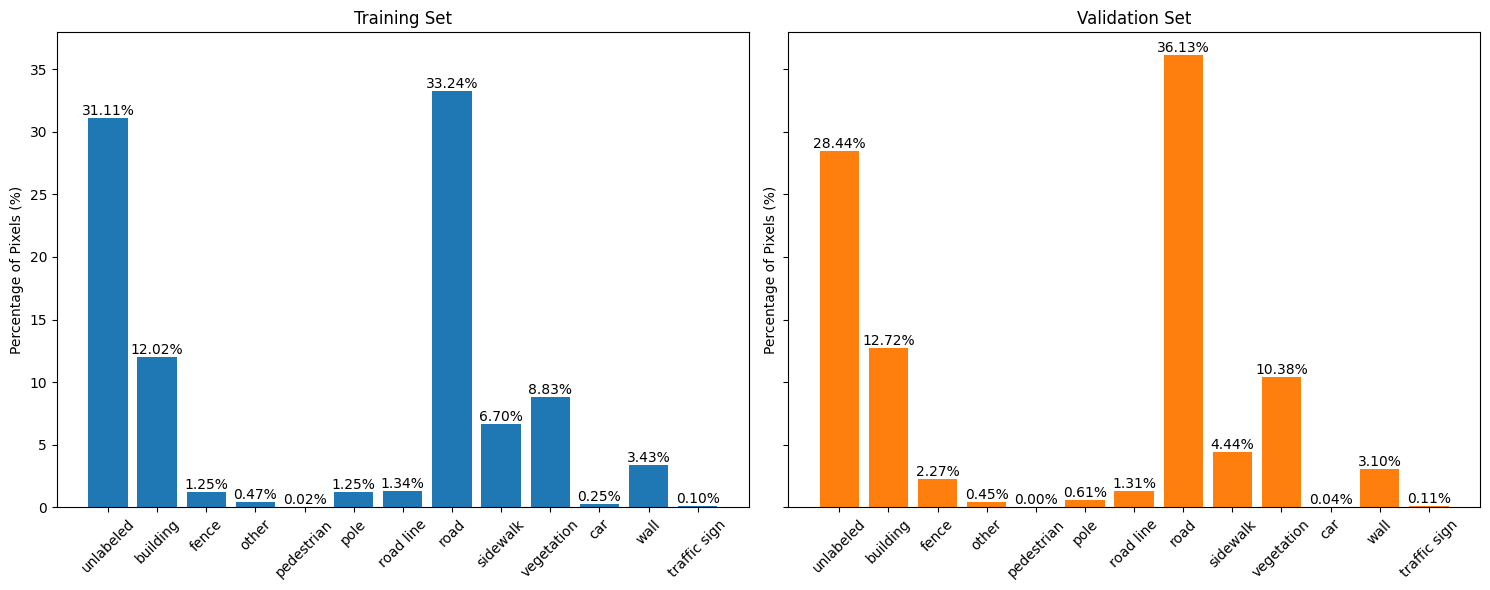

In [15]:
train_counts, train_freq = load_or_compute_frequencies(
    train_loader, num_classes, train_stats_path
)
val_counts, val_freq = load_or_compute_frequencies(
    val_loader, num_classes, val_stats_path
)
plot_class_distribution(
    class_names=class_names,
    train_freq=train_freq,
    val_freq=val_freq,
)

As shown in the plots above, both the training and validation sets exhibit a similar distribution of pixel frequencies across classes.

### 4.3 Outlier Exposure Dataset

As already said, the Residual Pattern Learning module is trained using Outlier Exposure. Below, we present an example image from the training set.

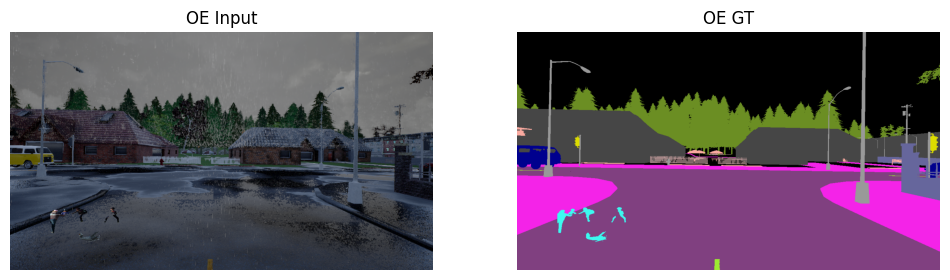

In [16]:
batch = next(iter(oe_train_loader))
images, masks = batch

images = unnormalize_image(images, image_mean, image_std)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(images[1].permute(1, 2, 0))
plt.title("OE Input")
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(visualize_mask(masks[1]))
plt.title("OE GT")
plt.axis("off")
plt.show()

## 5. Closed-Set Semantic Segmentation

We present the results of our best-performing model for the closed-set semantic segmentation task.  The model employs DeepLabV3+ with a ResNet50 backbone via the `segmentation_models_pytorch` library. Built on top of this architecture, the `UncertaintyModel` class allows the application of various post-hoc methods for anomaly detection. Among these, we selected the Max Logit approach, as it represents a strong baseline for which typical performance values are reported in the literature (approximately 10% AUPR on the StreetHazards test set). The model was trained for 20 epochs on the StreetHazards training set using a combined Dice-cross-entropy loss and the AdamW optimizer. Crucially, we will not train the model here. Instead, we load the weights from the checkpoint file specified in `phase1_best_segmenter.ckpt`, which was generated by running the training script (`train.py`).

In [17]:
segmentation_model = UncertaintyModel.load_from_checkpoint(
    checkpoint_path_seg,
    uncertainty_type="max_logit",
)
segmentation_model.to(device)
segmentation_model.eval();

We assess the computational efficiency of the model by measuring the number of parameters, GFLOPs, and inference time at the target resolution 720 x 1280.

In [18]:
summary(segmentation_model, input_size=(1, 3, image_height, image_width))

Layer (type:depth-idx)                                       Output Shape              Param #
UncertaintyModel                                             [1, 13, 720, 1280]        --
├─DeepLabV3Plus: 1-1                                         [1, 13, 720, 1280]        --
│    └─ResNetEncoder: 2-1                                    [1, 3, 720, 1280]         --
│    │    └─Conv2d: 3-1                                      [1, 64, 360, 640]         9,408
│    │    └─BatchNorm2d: 3-2                                 [1, 64, 360, 640]         128
│    │    └─ReLU: 3-3                                        [1, 64, 360, 640]         --
│    │    └─MaxPool2d: 3-4                                   [1, 64, 180, 320]         --
│    │    └─Sequential: 3-5                                  [1, 256, 180, 320]        215,808
│    │    └─Sequential: 3-6                                  [1, 512, 90, 160]         1,219,584
│    │    └─Sequential: 3-7                                  [1, 1024, 45, 80] 

In [19]:
runs = 2
dummy_input = torch.randn(1, 3, image_height, image_width).to(device)
gflops = compute_gflops(model=segmentation_model, x=dummy_input)
avg_time = measure_inference_time(model=segmentation_model, x=dummy_input, runs=runs)

results = pd.DataFrame(
    [
        {
            "Model": "Segmentation",
            "Input Size": f"{image_height}x{image_width}",
            "GFLOPs": gflops,
            "Inference Time (ms)": avg_time,
        }
    ]
)

loss_fn, loss_fn.loss_a, loss_fn.loss_b, model.segmentation_head.2, test_iou_closed, train_iou, val_iou


In [20]:
results

Model Input Size      GFLOPs  Inference Time (ms)
0  Segmentation   720x1280  129.341555            19.269824

### 5.1 Training Curves

We visualize the loss and mIoU curves across training epochs.

In [21]:
run_id = "6gawciji"

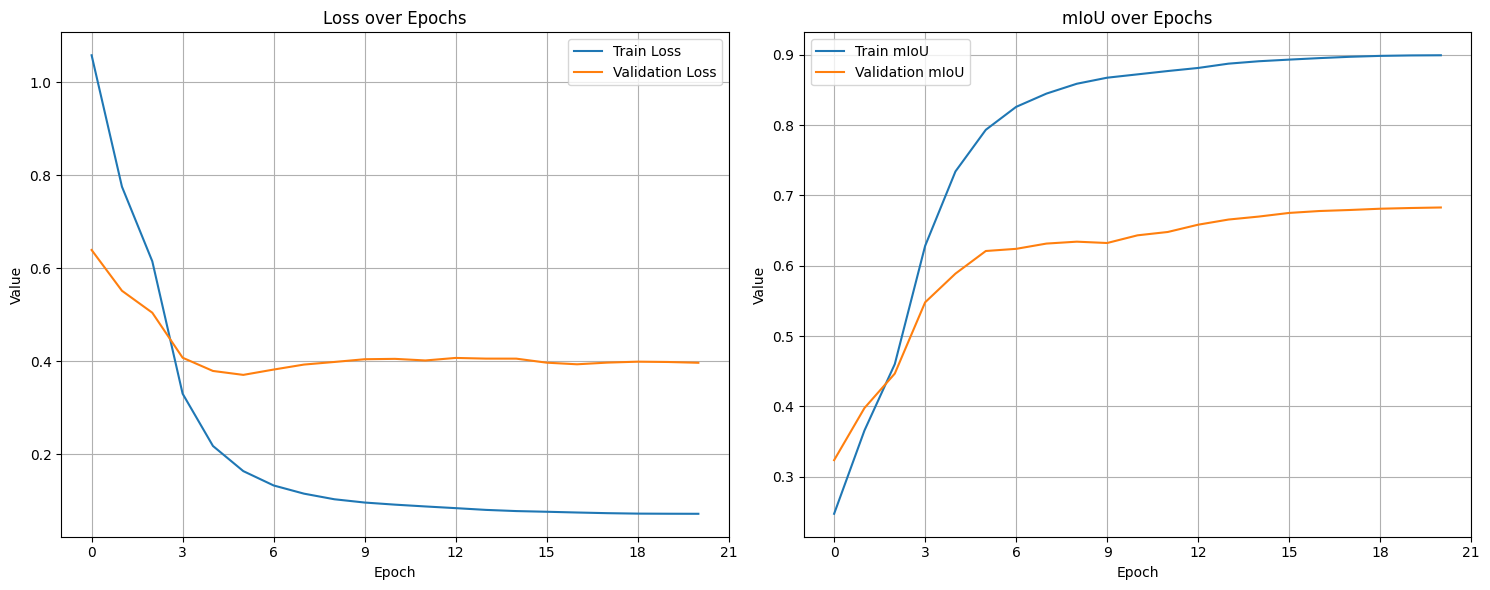

In [22]:
plot_metrics_dual_axis(
    runs=[run_id],
    metrics_left=("train_loss_epoch", "val_loss"),
    metrics_right=("train_miou", "val_miou"),
    smooth=True,
    labels={
        "train_loss_epoch": "Train Loss",
        "val_loss": "Validation Loss",
        "train_miou": "Train mIoU",
        "val_miou": "Validation mIoU",
    },
    title_left="Loss over Epochs",
    title_right="mIoU over Epochs",
)

### 5.2 Quantitative Results on the Validation Set

Finally, we show the quantitative results on the validation set.

In [23]:
csv_path = Path("stats/val_per_class_iou.csv")
per_class_iou, df_iou = load_or_compute_per_class_iou(
    model=segmentation_model,
    dataloader=val_loader,
    class_names=class_names,
    ignore_index=ANOMALY_ID,
    device=device,
    csv_path=csv_path,
)

Loading stored IoU values from stats/val_per_class_iou.csv


In [24]:
df_iou = df_iou.set_index("Class").T
df_iou

Class    unlabeled  building  fence  other  pedestrian   pole  road line  \
IoU (%)      87.29     80.43  59.54  48.31       70.69  39.74      78.46   

Class     road  sidewalk  vegetation    car   wall  traffic sign  
IoU (%)  94.75     83.26       88.23  59.96  40.41         57.07

The results indicate that the class with the lowest IoU is *pole*, likely due to the substantial variability within this category (e.g., lampposts as well as supporting structures of overpasses). This is followed by *wall* and *other*, with the latter likely for the same reason as *pole*.

In [25]:
val_miou = get_best_metric(run_name=run_id, metric="val_miou") * 100
val_miou_closed = get_best_metric(run_name=run_id, metric="val_miou_closed") * 100
val_aupr_anomaly = get_best_metric(run_name=run_id, metric="val_aupr_anomaly") * 100

rows = [
    {
        "Val mIoU": val_miou,
        "Val mIoU with anomalies": val_miou_closed,
        "Val AUPR with anomalies": val_aupr_anomaly,
    }
]

df_results = pd.DataFrame(rows)
df_results = df_results.style.format(
    {
        "Val mIoU": "{:.2f}",
        "Val mIoU with anomalies": "{:.2f}",
        "Val AUPR with anomalies": "{:.2f}",
    }
).hide(axis="index")
df_results

The two metrics, Val mIoU and Val AUPR with anomalies, correspond to the values obtained on the standard StreetHazards validation set and on the validation set with OOD samples, respectively. When selecting the model, we also ensured that these two values remained consistent, as this indicates that the model maintains its segmentation capabilities even in the presence of anomalies.

### 5.3 Qualitative Results (Preliminary Evaluation)

A qualitative visual inspection is performed to verify the model's behaviour, while a more in-depth analysis is presented in subsequent sections.

In [26]:
def run_inference(model, images, device):
    images = images.to(device)

    with torch.no_grad():
        logits = model(images)
        preds = torch.argmax(logits, dim=1)
        anomaly_scores = model._compute_anomaly_scores(logits, preds).cpu()

    return preds.cpu(), anomaly_scores.cpu()

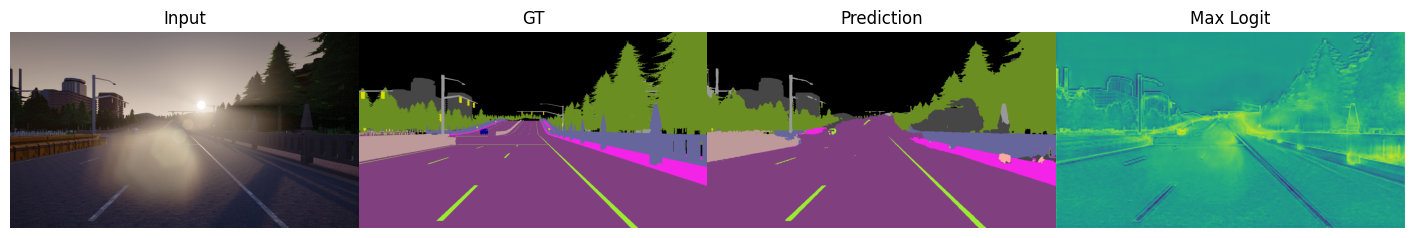

In [27]:
batch = next(iter(val_loader))
images, masks = batch

pred_mask, anomaly_scores = run_inference(segmentation_model, images, device)
image = unnormalize_image(images[0].cpu(), image_mean, image_std)

plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(visualize_mask(masks[0]))
plt.title("GT")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(visualize_mask(pred_mask[0]))
plt.title("Prediction")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(anomaly_scores[0], cmap="viridis")
plt.title("Max Logit")
plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

The example shows what happens when there are light effects in the image. In regions affected by glare, the segmentation has become less precise and the road markings become less visible. This inaccuracy is reflected in the anomaly scores obtained using a post-hoc method such as Max Logit. 

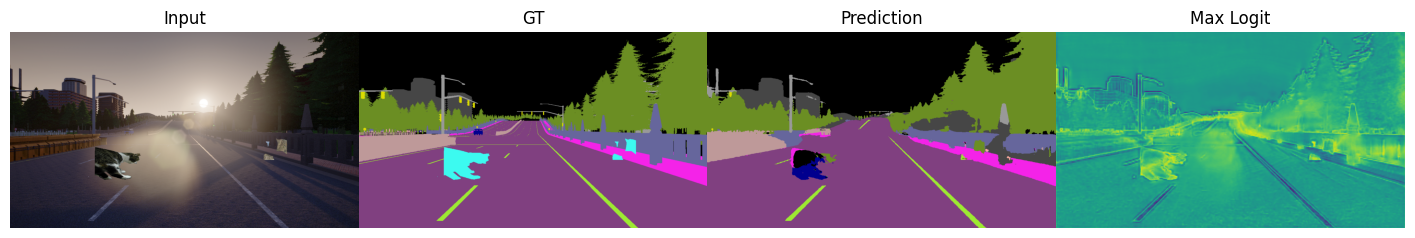

In [28]:
batch = next(iter(oe_val_loader))
images, masks = batch

pred_mask, anomaly_scores = run_inference(segmentation_model, images, device)
image = unnormalize_image(images[1].cpu(), image_mean, image_std)

plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(visualize_mask(masks[1]))
plt.title("GT")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(visualize_mask(pred_mask[1]))
plt.title("Prediction")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(anomaly_scores[1], cmap="viridis")
plt.title("Max Logit")
plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Interestingly, let's look at what happens when an anomaly is present. The anomaly is located on the road and is predicted with a mix of pixels, including some classified as background. The model appears to be very confident in this prediction, and Max Logit does not highlight a strongly anomalous region. This clearly shows us the limitations of post-hoc methods.

## 6. Anomaly Detection

The RPL module has the same architecture as the ASPP block of the original network. Instead of initializing RPL from scratch, it partially loads the weights from the pre-trained ASPP block. This helps the module converge faster since it has to learn "residual" features rather than standard ones. The hyperparameters used for training are available in the `config_residual.yaml` file.

In [29]:
anomaly_detection_model = ResidualPatternLearningModel.load_from_checkpoint(
    checkpoint_path_rpl,
    base_segmenter=segmentation_model.model,
    outlier_class_idx=ANOMALY_ID,
    score_type="energy",
    use_gaussian=True,
)
anomaly_detection_model.eval()
anomaly_detection_model.to(device);

In [30]:
runs = 2
dummy_input = torch.randn(1, 3, image_height, image_width).to(device)
gflops = compute_gflops(model=anomaly_detection_model, x=dummy_input)
avg_time = measure_inference_time(
    model=anomaly_detection_model, x=dummy_input, runs=runs
)
results.loc[len(results)] = {
    "Model": "Anomaly Detection",
    "Input Size": f"{image_height}x{image_width}",
    "GFLOPs": gflops,
    "Inference Time (ms)": avg_time,
}

backbone, backbone.decoder, backbone.decoder.aspp, backbone.decoder.aspp.0, backbone.decoder.aspp.0.convs.0, backbone.decoder.aspp.0.convs.0.0, backbone.decoder.aspp.0.convs.0.1, backbone.decoder.aspp.0.convs.0.2, backbone.decoder.aspp.0.convs.1, backbone.decoder.aspp.0.convs.1.0, backbone.decoder.aspp.0.convs.1.0.0, backbone.decoder.aspp.0.convs.1.0.1, backbone.decoder.aspp.0.convs.1.1, backbone.decoder.aspp.0.convs.1.2, backbone.decoder.aspp.0.convs.2, backbone.decoder.aspp.0.convs.2.0, backbone.decoder.aspp.0.convs.2.0.0, backbone.decoder.aspp.0.convs.2.0.1, backbone.decoder.aspp.0.convs.2.1, backbone.decoder.aspp.0.convs.2.2, backbone.decoder.aspp.0.convs.3, backbone.decoder.aspp.0.convs.3.0, backbone.decoder.aspp.0.convs.3.0.0, backbone.decoder.aspp.0.convs.3.0.1, backbone.decoder.aspp.0.convs.3.1, backbone.decoder.aspp.0.convs.3.2, backbone.decoder.aspp.0.convs.4, backbone.decoder.aspp.0.convs.4.0, backbone.decoder.aspp.0.convs.4.1, backbone.decoder.aspp.0.convs.4.2, backbone.dec

In [31]:
results

Model Input Size      GFLOPs  Inference Time (ms)
0       Segmentation   720x1280  129.341555            19.269824
1  Anomaly Detection   720x1280  147.987891            22.530913

Adding the RPL module results in an increase of approximately 3 seconds in inference time, which must be taken into account in contexts where decisions need to be made quickly.

### 6.1 Training Curves

In [32]:
run_id = "bqsy9901"

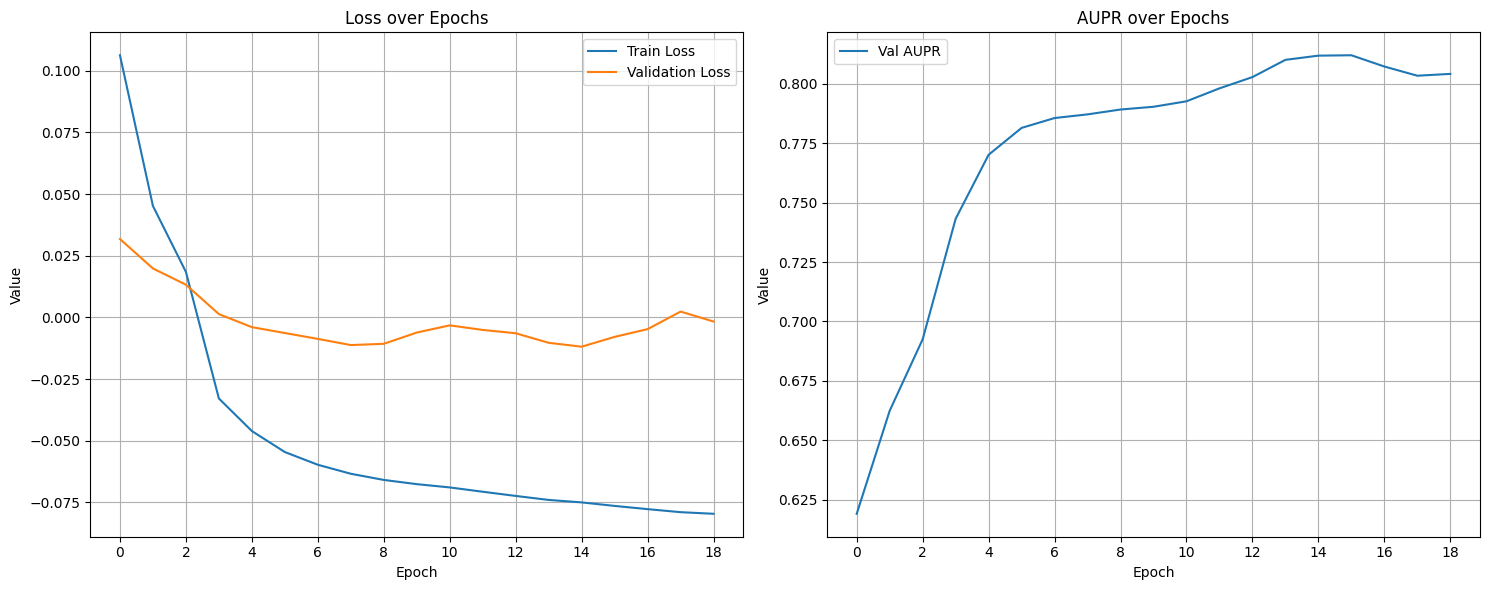

In [33]:
plot_metrics_dual_axis(
    runs=[run_id],
    metrics_left=("train_loss_epoch", "val_loss"),
    metrics_right=("train_aupr", "val_aupr"),
    smooth=True,
    labels={
        "train_loss_epoch": "Train Loss",
        "val_loss": "Validation Loss",
        "val_aupr": "Val AUPR",
    },
    title_left="Loss over Epochs",
    title_right="AUPR over Epochs",
)

It is important to note that the task of distinguishing COCO objects from StreetHazards is very simple; in fact, we reach a very high value after only a few epochs.

### 6.2 Quantitative Results on the Validation Set

In [34]:
val_aupr = get_best_metric(run_name=run_id, metric="val_aupr")

rows = [
    {
        "Val AUPR": val_aupr,
    }
]

df_results = pd.DataFrame(rows)
df_results.style.hide(axis="index")

### 6.3 Qualitative Results (Preliminary Evaluation)

In [35]:
oe_val_loader = oe_data_module.val_dataloader()
images, masks = next(iter(oe_val_loader))

In [36]:
with torch.no_grad():
    images = images.to(device)

    base_logits, rpl_logits = anomaly_detection_model(images)
    base_heatmap = -base_logits.max(dim=1).values

    anomaly_heatmap = anomaly_detection_model._compute_anomaly_scores(rpl_logits)

In [37]:
images = unnormalize_image(images.cpu(), image_mean, image_std)

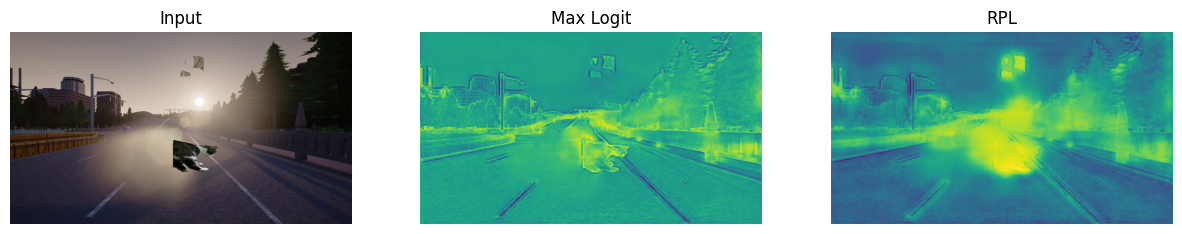

In [38]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
plt.imshow(images[1].permute(1, 2, 0))
plt.title("Input")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(base_heatmap[1].cpu().numpy(), cmap="viridis")
plt.title("Max Logit")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(anomaly_heatmap[1].cpu().numpy(), cmap="viridis")
plt.title("RPL")
plt.axis("off")
plt.show()

We can compare Max Logit and RPL. We immediately see that the model is much more confident in excluding the road and sky as possible anomalies. The anomaly inserted into the image is correctly identified, but the uncertainty caused by the light remains.

## 7. Ablation Study

We now discuss and justify the design choices that led to the final model. The ablation study is divided into two parts: one focusing on the segmentation network and one on the RPL module. The procedure was as follows:

1. We defined a robust baseline consisting of ResNet50, Cross Entropy loss, and random horizontal flip.
2. We evaluated the impact of modifying individual components relative to this baseline.
3. Components that consistently improved both mIoU and AUPR were integrated into the final configuration.

For computational efficiency, all ablation experiments were conducted at a reduced resolution of 1024×576. Once the best configuration was identified, the model was retrained at full resolution and used as the final model.

### 7.1 Segmentation network

### Loss Function

In [39]:
loss_ablation = [
    ("rm93we79", "Cross Entropy (Baseline)"),
    ("mxzmryit", "Focal Loss"),
    ("4cxn8iu9", "CE + Dice"),
    ("6btkvxr5", "Lovasz"),
]
rows = []

for run_id, loss_name in loss_ablation:
    rows.append(
        {
            "Loss": loss_name,
            "Val mIoU": get_best_metric(run_id, "val_miou", mode="max") * 100,
            "Val mIoU with anomalies": get_best_metric(
                run_id, "val_miou_closed", mode="max"
            )
            * 100,
            "Val AUPR": get_best_metric(run_id, "val_aupr_anomaly", mode="max"),
        }
    )

df_loss_ablation = pd.DataFrame(rows)
df_loss_ablation = df_loss_ablation.style.format(
    {
        "Val mIoU": "{:.2f}",
        "Val mIoU with anomalies": "{:.2f}",
        "Val AUPR": "{:.2f}",
    }
).hide(axis="index")
df_loss_ablation

The results show that the model trained with the Lovász loss achieves the highest segmentation performance, with an mIoU of 66.45%. However, this comes at the cost of a reduced AUPR, which supports our decision to incorporate a proxy for anomaly-detection capability during model selection. This behavior suggests that the model is overconfident. The other losses yield a validation mIoU lower than that obtained with Cross Entropy + Dice.

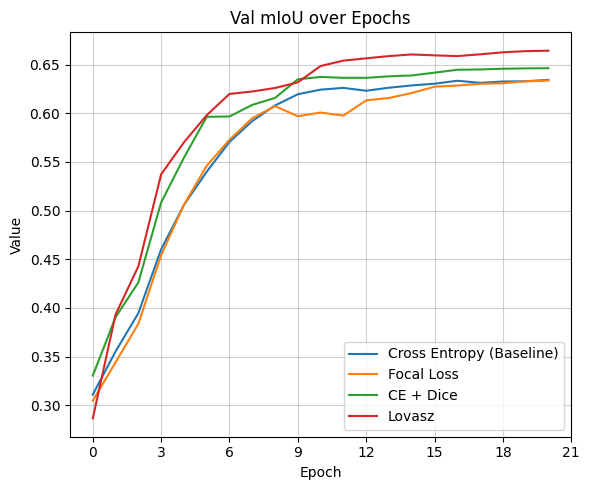

In [40]:
plot_runs(
    runs=[r[0] for r in loss_ablation],
    labels=[r[1] for r in loss_ablation],
    metrics=[("val_miou", "Val mIoU")],
    smooth=True,
    title="Val mIoU over Epochs",
    figsize=(6, 5),
)

In this case, it would not make sense to compare the loss values, since different losses naturally operate on different scales.

### Data Augmentation

In [41]:
augmentation_ablation = [
    ("rm93we79", "Baseline"),
    ("2gdw3njw", "No Augmentation"),
    ("7oz3d1k5", "ColorJitter"),
    ("agzzks6y", "RandomCrop"),
]

rows = []

for run_id, aug_name in augmentation_ablation:
    rows.append(
        {
            "Augmentation": aug_name,
            "Val mIoU": get_best_metric(run_id, "val_miou", "max") * 100,
            "Val mIoU with anomalies": get_best_metric(
                run_id, "val_miou_closed", mode="max"
            )
            * 100,
            "Val AUPR": get_best_metric(run_id, "val_aupr_anomaly", mode="max"),
        }
    )

df_aug_ablation = pd.DataFrame(rows)
df_aug_ablation = df_aug_ablation.style.format(
    {
        "Val mIoU": "{:.2f}",
        "Val mIoU with anomalies": "{:.2f}",
        "Val AUPR": "{:.2f}",
    }
).hide(axis="index")
df_aug_ablation

As we can see, both metrics improve when ColorJitter is applied. Furthermore, the performance degradation observed when no augmentations are used is expected.

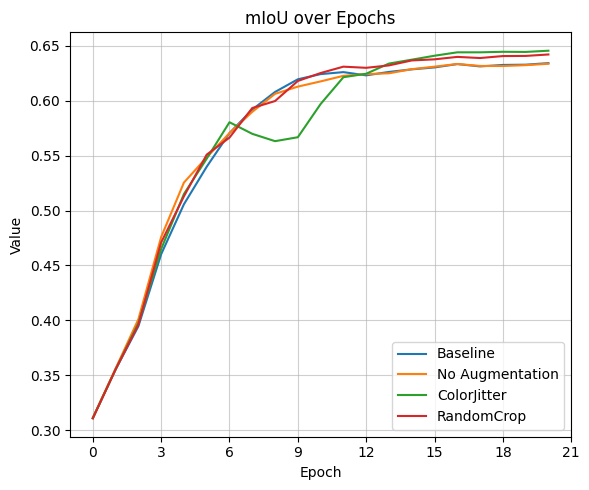

In [42]:
plot_runs(
    runs=[r[0] for r in augmentation_ablation],
    labels=[r[1] for r in augmentation_ablation],
    metrics=[("val_miou", "Val mIoU")],
    smooth=True,
    title="mIoU over Epochs",
    figsize=(6, 5),
)

### Learning Rate

In [43]:
lr_ablation = [
    ("rm93we79", "Baseline LR"),  # 0.0002
    ("w8y6uyoc", "High LR"),  # 0.0004
    ("u00mg3dc", "Low LR"),  # 0.0001
]

rows = []

for run_id, lr_label in lr_ablation:
    rows.append(
        {
            "LR Setting": lr_label,
            "Val mIoU": get_best_metric(run_id, "val_miou", "max") * 100,
            "Val mIoU with anomalies": get_best_metric(
                run_id, "val_miou_closed", mode="max"
            )
            * 100,
            "Val AUPR": get_best_metric(run_id, "val_aupr_anomaly", mode="max"),
        }
    )

df_lr_ablation = pd.DataFrame(rows)
df_lr_ablation = df_lr_ablation.style.format(
    {
        "Val mIoU": "{:.2f}",
        "Val mIoU with anomalies": "{:.2f}",
        "Val AUPR": "{:.2f}",
    }
).hide(axis="index")
df_lr_ablation

Lowering the learning rate to 0.0001 or increasing it to 0.0004 does not change the performance significantly.

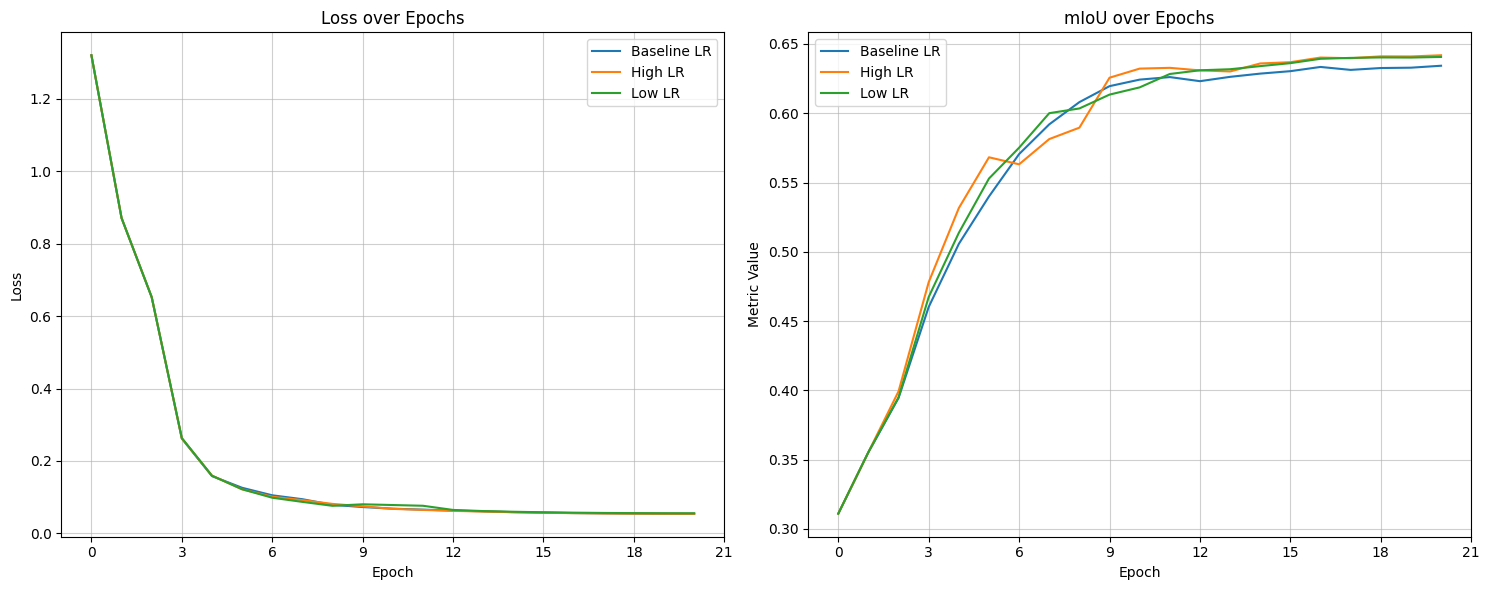

In [44]:
plot_runs_dual_axis(
    runs=[r[0] for r in lr_ablation],
    labels=[r[1] for r in lr_ablation],
    metrics_left=[("train_loss_epoch", "Train Loss")],
    metrics_right=[("val_miou", "Val mIoU")],
    smooth=True,
    title_left="Loss over Epochs",
    title_right="mIoU over Epochs",
)

### Backbone

In [45]:
backbone_ablation = [
    ("rm93we79", "ResNet50"),
    ("jc7r94wt", "ResNet101"),
    ("ef20hpdx", "EfficientNet-B2"),
]

rows = []

for run_id, backbone in backbone_ablation:
    rows.append(
        {
            "Backbone": backbone,
            "Val mIoU": get_best_metric(run_id, "val_miou", "max") * 100,
            "Val mIoU with anomalies": get_best_metric(
                run_id, "val_miou_closed", mode="max"
            )
            * 100,
            "Val AUPR": get_best_metric(run_id, "val_aupr_anomaly", mode="max"),
        }
    )

df_backbone_ablation = pd.DataFrame(rows)
df_backbone_ablation = df_backbone_ablation.style.format(
    {
        "Val mIoU": "{:.2f}",
        "Val mIoU with anomalies": "{:.2f}",
        "Val AUPR": "{:.2f}",
    }
).hide(axis="index")
df_backbone_ablation

EfficientNetB2 proved to handle uncertainty better than ResNet50, achieving the highest AUPR on the validation set. However, we chose to use ResNet50 to maintain consistency with the literature.

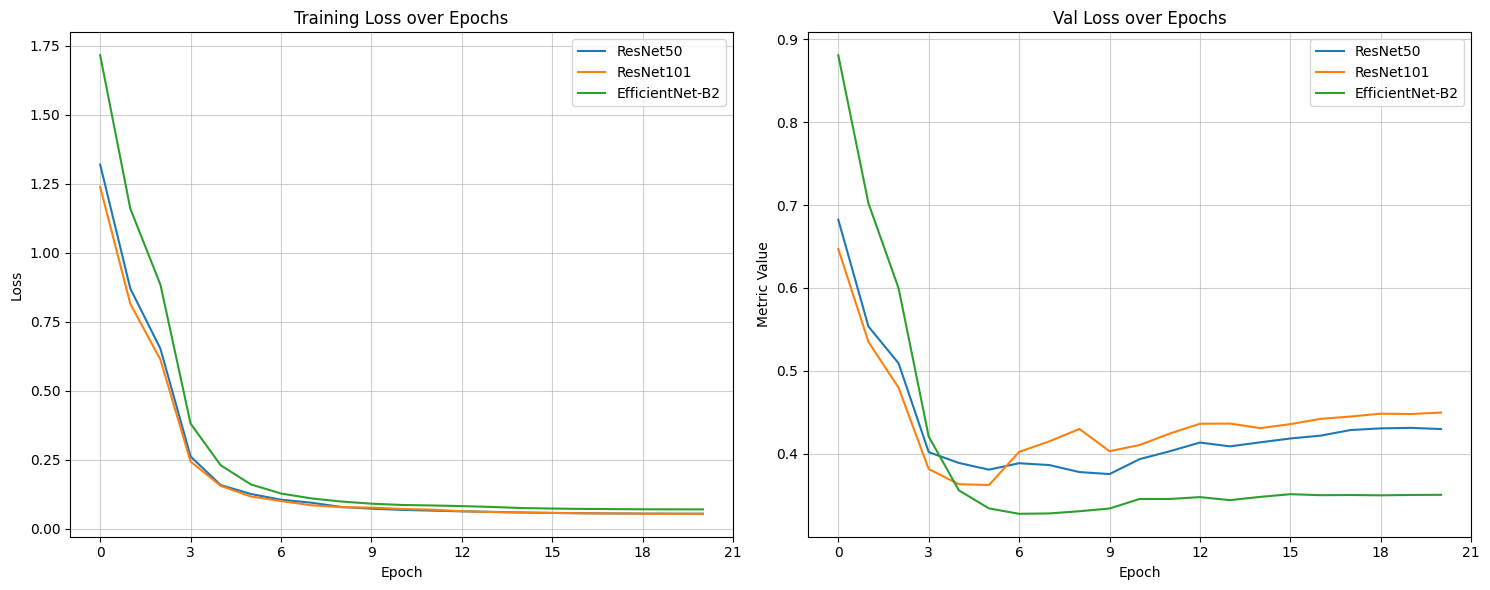

In [46]:
plot_runs_dual_axis(
    runs=[r[0] for r in backbone_ablation],
    labels=[r[1] for r in backbone_ablation],
    metrics_left=[("train_loss_epoch", "Train Loss")],
    metrics_right=[("val_loss", "Val Loss")],
    smooth=True,
    title_left="Training Loss over Epochs",
    title_right="Val Loss over Epochs",
)

We compared the ResNet-50 and ResNet-101 backbones. Although both models exhibit similar learning curves (left axis), ResNet-50 shows better generalization performance on the validation set (right axis). This suggests that the larger capacity of ResNet-101 leads to overfitting on the StreetHazards dataset. Therefore, we selected ResNet-50 for our pipeline.

### 7.2 Anomaly Detector

Ablation on the anomaly detector turned out to be much more challenging than ablation on the segmentation network, due to a mismatch between the test set and the training set used to train the RPL. 

### Learning Rate

In [47]:
detector_lr_ablation = [
    ("pik5pjh2", "LR 1e-5"),
    ("fbu87rbx", "LR 5e-6"),
    ("w6rcxckj", "LR 3e-4"),
]

rows = []

for run_id, label in detector_lr_ablation:
    rows.append(
        {"LR": label, "Val AUPR": get_best_metric(run_id, "val_aupr", "max") * 100}
    )

df_det_lr = pd.DataFrame(rows)
df_det_lr = df_det_lr.style.format(
    {
        "Val AUPR": "{:.2f}",
    }
).hide(axis="index")
df_det_lr

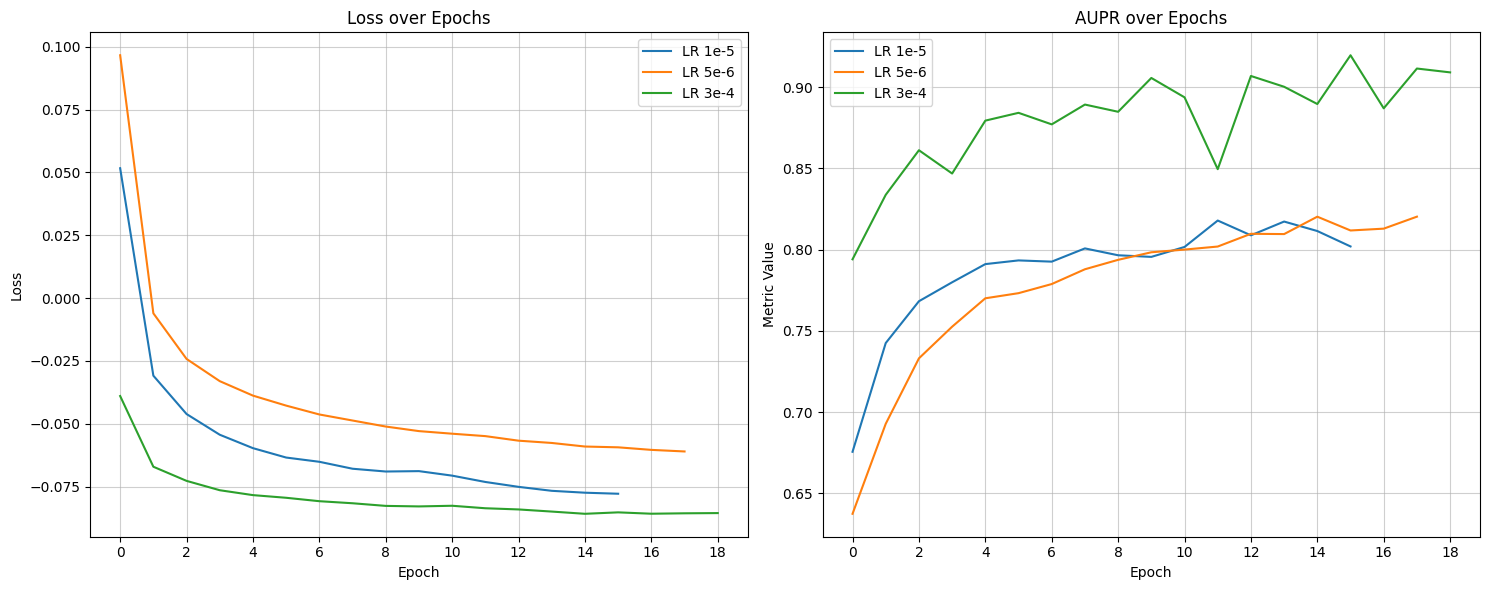

In [48]:
plot_runs_dual_axis(
    runs=[r[0] for r in detector_lr_ablation],
    labels=[r[1] for r in detector_lr_ablation],
    metrics_left=[("train_loss_epoch", "Train Loss")],
    metrics_right=[("val_aupr", "Val AUPR")],
    smooth=False,
    title_left="Loss over Epochs",
    title_right="AUPR over Epochs",
)

We chose to use low learning rates, unlike what we would have done if we had simply selected the model with the highest AUPR. The rationale is twofold. First, lower learning rates help prevent overfitting on Pascal VOC objects, whose distribution differs significantly from that of StreetHazards. Second, using very high learning rates results in strong AUPR instability, as shown in the graph.

### Injection Probability

In [49]:
inject_ablation = [
    ("ytncf9mw", "Inject 0.3"),
    ("pik5pjh2", "Inject 0.5 (Baseline)"),
    ("m8au17hz", "Inject 0.8"),
    ("f1nb2dlz", "Inject 1.0"),
]

rows = []

for run_id, label in inject_ablation:
    rows.append(
        {"Config": label, "Val AUPR": get_best_metric(run_id, "val_aupr", "max")}
    )

df_inject = pd.DataFrame(rows)
df_inject = df_inject.style.format(
    {
        "Val AUPR": "{:.2f}",
    }
).hide(axis="index")
df_inject

Here as well, the choice is somewhat unconventional. We choose to use an anomaly injection probability of 0.5, even though the validation AUPR would suggest using a higher value. Exposing the model to clean images and anomalous images with equal probability clearly benefits training.

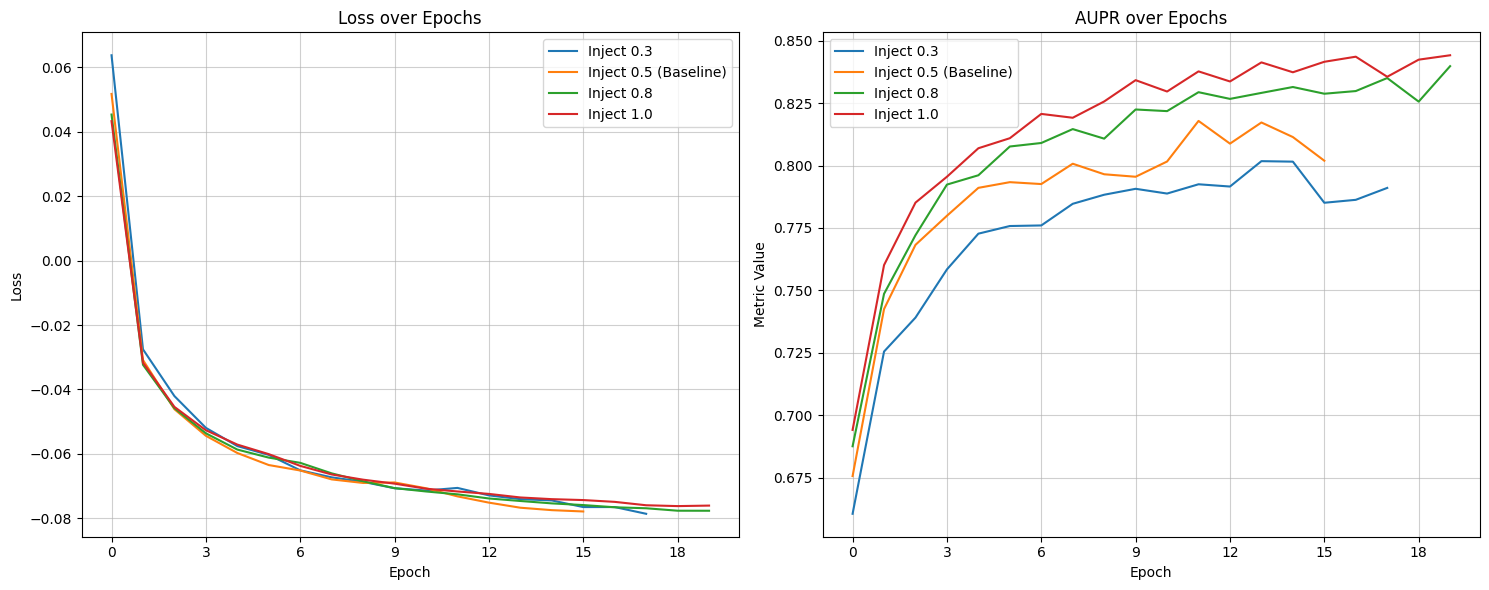

In [50]:
plot_runs_dual_axis(
    runs=[r[0] for r in inject_ablation],
    labels=[r[1] for r in inject_ablation],
    metrics_left=[("train_loss_epoch", "Train Loss")],
    metrics_right=[("val_aupr", "Val AUPR")],
    smooth=False,
    title_left="Loss over Epochs",
    title_right="AUPR over Epochs",
)

### 7.3 Comparison with Post-hoc Methods

Post-hoc methods allow for anomaly detection without requiring additional training. They are computationally efficient and therefore suitable for scenarios in which retraining the full model is not an option. However, their performance is typically lower than that of other methods.

### MSP

The simplest method is Maximum Softmax Probability (MSP). This method relies on the assumption that in-distribution examples exhibit higher confidence than out-of-distribution examples. It uses the negative of the maximum softmax probability as the anomaly score. However, it performs poorly on realistic in-distribution datasets with a large number of classes.

In [51]:
batch = next(iter(oe_test_loader))
images, masks = batch

In [52]:
segmentation_model.hparams.uncertainty_type = "msp"
segmentation_model.to(device);

In [53]:
pred_mask, anomaly_scores = run_inference(segmentation_model, images, device)
unnormalize_images = unnormalize_image(images.cpu(), image_mean, image_std)

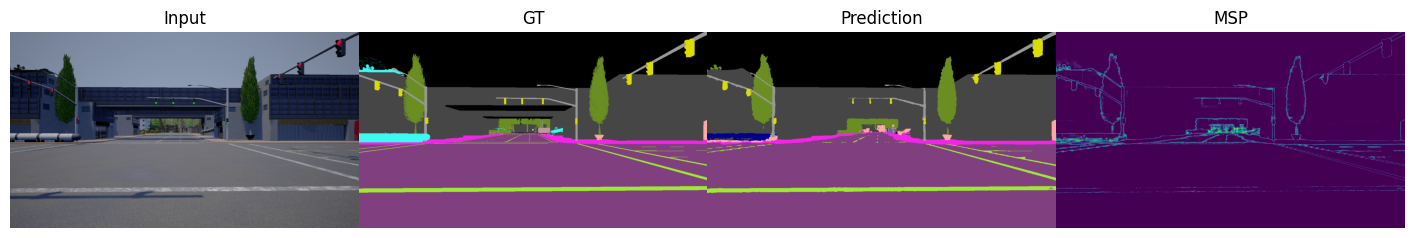

In [54]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
plt.imshow(unnormalize_images[0].permute(1, 2, 0))
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(visualize_mask(masks[0]))
plt.title("GT")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(visualize_mask(pred_mask[0]))
plt.title("Prediction")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(anomaly_scores[0], cmap="viridis")
plt.title("MSP")
plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Max Logit

MaxLogit is one of the most widely used OOD detection methods. It was introduced by Hendrycks et al. [2]. It addresses the limitations of MSP by using the negative of the maximum unnormalized logit as the anomaly score, $-\max_k f(x)_k$. Because logits are unnormalized, they are not affected by the number of classes.

In [55]:
segmentation_model.hparams.uncertainty_type = "max_logit"

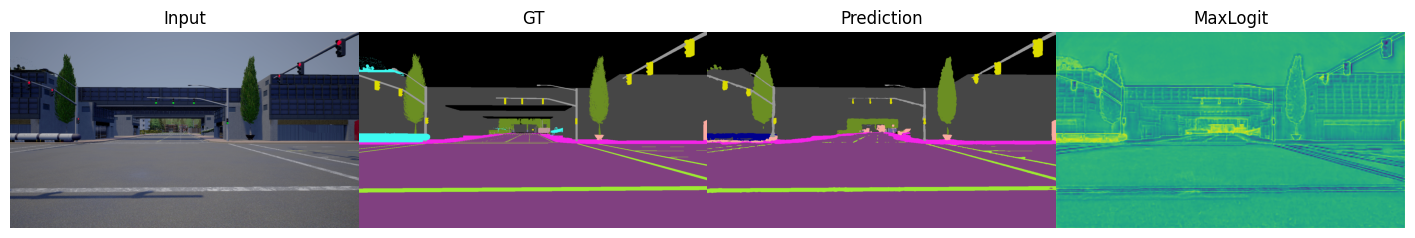

In [56]:
pred_mask, anomaly_scores = run_inference(segmentation_model, images, device)

plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
plt.imshow(unnormalize_images[0].permute(1, 2, 0))
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(visualize_mask(masks[0]))
plt.title("GT")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(visualize_mask(pred_mask[0]))
plt.title("Prediction")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(anomaly_scores[0], cmap="viridis")
plt.title("MaxLogit")
plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Building upon these methods, which constitute a solid baseline, several works have sought to improve performance. Among these, one of the most well-known is Standardized Max Logits (SML) [3]. SML proposes the idea of ​​standardizing the max logits in a class-wise manner. Standardizing the max logits aligns the distributions of max logits in each predicted class, so it enables to reflect the relative meanings of values within a class.

In [57]:
segmentation_model.hparams.uncertainty_type = "sml"
segmentation_model._load_sml_statistics("stats/sml_stats.pt")
segmentation_model.sml_means = segmentation_model.sml_means.to(device)
segmentation_model.sml_stds = segmentation_model.sml_stds.to(device)

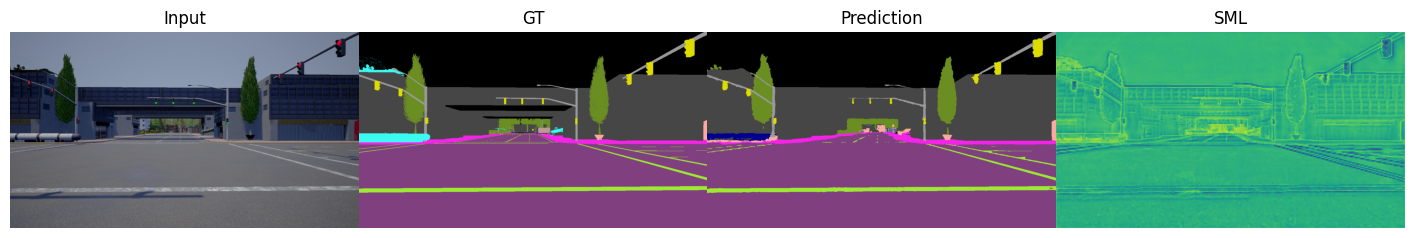

In [58]:
pred_mask, anomaly_scores = run_inference(segmentation_model, images, device)

plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
plt.imshow(unnormalize_images[0].permute(1, 2, 0))
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(visualize_mask(masks[0]))
plt.title("GT")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(visualize_mask(pred_mask[0]))
plt.title("Prediction")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(anomaly_scores[0], cmap="viridis")
plt.title("SML")
plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Iterative Boundary Suppression

Due to the class changes, the boundary pixels tend to have low prediction scores (i.e., high anomaly scores) compared to the non-boundary pixels. The idea is remove such false positives by replacing the high anomaly scores of boundary regions with low anomaly scores of neighboring non-boundary pixels.

### Dilated Smoothing

In order to remove the remaining false positives in both boundary and non-boundary regions, we smooth them using the neighboring pixels based on the intuition that local consistency exists among the pixels in a local region.

In [59]:
pp.SELEM, pp.SELEM_DILATION, pp.DILATION_KERNELS = pp.build_structuring_elements(
    device=device
)

In [60]:
segmentation_model.boundary_postprocessor = BoundarySuppressionWithSmoothing(
    boundary_suppression=True,
    dilated_smoothing=False,
).to(device)

In [61]:
pred_mask, out_ibs = run_inference(segmentation_model, images, device)

In [62]:
segmentation_model.boundary_postprocessor = BoundarySuppressionWithSmoothing(
    boundary_suppression=True,
    dilated_smoothing=True,
).to(device)

In [63]:
pred_mask, out_ds = run_inference(segmentation_model, images, device)

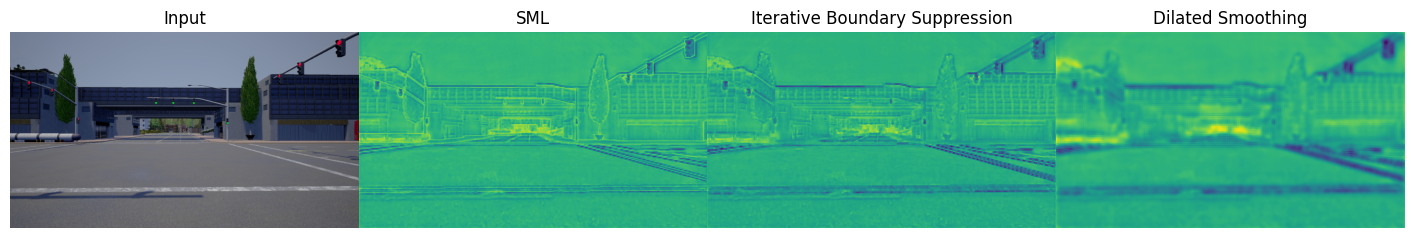

In [64]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
plt.imshow(
    unnormalize_image(images[0].cpu(), mean=image_mean, std=image_std).permute(1, 2, 0)
)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(anomaly_scores[0], cmap="viridis")
plt.title("SML")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(out_ibs[0])
plt.title("Iterative Boundary Suppression")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(out_ds[0])
plt.title("Dilated Smoothing")
plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

Our results empirically demonstrate that, contrary to common assumptions, SML is not always an effective method. SML fails (and performs worse than MaxLogit) when the model misclassifies an anomaly with very high confidence. In such cases, the maximum logit of an anomalous pixel is not lower than that of in-distribution (ID) pixels. Consequently, for each class, the distributions of max logits for ID and OOD pixels can overlap significantly.

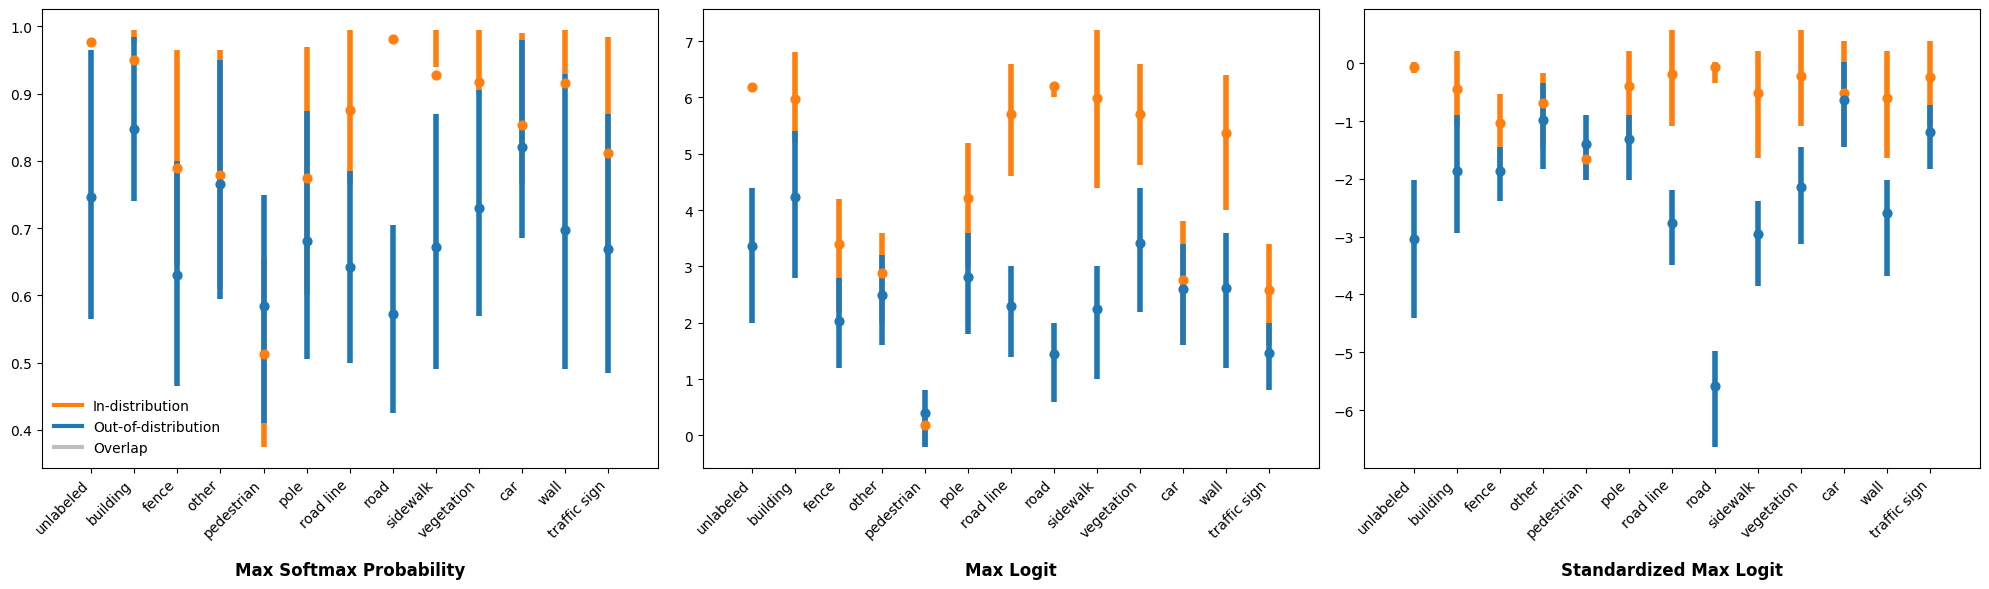

In [65]:
create_statistics_plots(full_stat_path, class_names=class_names)

### Metric Learning

To benchmark the RPL approach against a different paradigm, we also evaluated a Metric Learning approach. The goal of this method is to learn clusters such that anomalies lie far from them in feature space. We used the pre-trained encoder and decoder weights provided by the [official repository](https://github.com/Jun-CEN/Open-World-Semantic-Segmentation/tree/main).

In [66]:
metric_learning_model = MetricLearningModel(
    encoder_path="pretrained/encoder_epoch_20.pth",
    decoder_path="pretrained/decoder_epoch_20.pth",
)
metric_learning_model.to(device)
metric_learning_model.eval();

In [67]:
def normalize_array(x):
    min_val = x.min()
    max_val = x.max()

    if max_val == min_val:
        return x - min_val

    return (x - min_val) / (max_val - min_val)

In [68]:
batch = next(iter(oe_test_loader))
images, masks = batch

In [69]:
image = images[0].unsqueeze(0).to(device)
seg_label = masks[0].unsqueeze(0).to(device)
seg_np = seg_label.squeeze().cpu().numpy()
H, W = seg_label.shape[-2:]

In [70]:
with torch.no_grad():
    metric_learning_model.decoder.use_softmax = True
    scores, _ = metric_learning_model(image, seg_size=(H, W))
    metric_learning_model.decoder.use_softmax = False

    scores = scores.squeeze(0)

    pred_mask = torch.argmax(scores, dim=0).cpu().numpy()

    dissimilarity = torch.sum(scores, dim=0)
    dissimilarity = (-dissimilarity).cpu().numpy()
    dissimilarity = np.clip(dissimilarity, None, 400)
    confidence = normalize_array(dissimilarity)
    score = -confidence

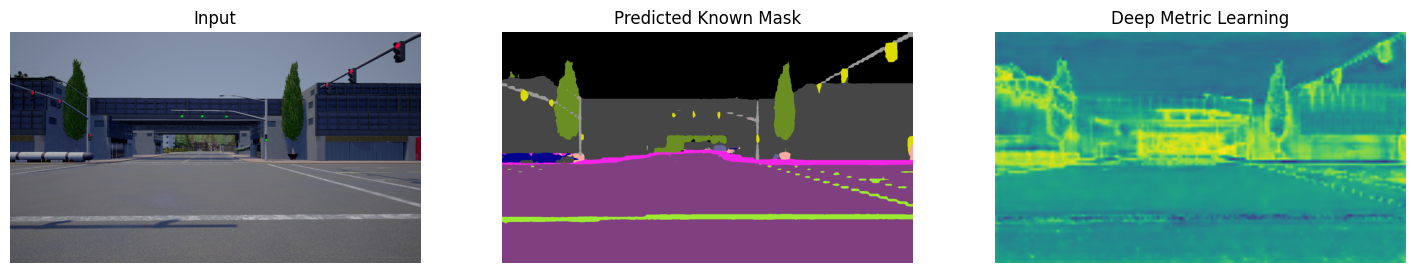

In [71]:
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.imshow(
    unnormalize_image(images[0].cpu(), mean=image_mean, std=image_std).permute(1, 2, 0)
)
plt.title("Input")
plt.axis("off")
plt.subplot(1, 3, 2)
plt.imshow(visualize_mask(torch.tensor(pred_mask)))
plt.title("Predicted Known Mask")
plt.axis("off")
plt.subplot(1, 3, 3)
plt.imshow(score, cmap="viridis")
plt.title("Deep Metric Learning")
plt.axis("off")
plt.show()

## 8. Evaluation on Test Set

Finally, we evaluate the model on the StreetHazards test set.

### 8.1 Quantitative Results

In [72]:
csv_path = Path("stats/test_per_class_iou.csv")
per_class_iou, df_iou = load_or_compute_per_class_iou(
    model=segmentation_model,
    dataloader=oe_test_loader,
    class_names=class_names,
    ignore_index=ANOMALY_ID,
    device=device,
    csv_path=csv_path,
)

Loading stored IoU values from stats/test_per_class_iou.csv


In [73]:
df_iou = df_iou.set_index("Class").T
df_iou

Class    unlabeled  building  fence  other  pedestrian   pole  road line  \
IoU (%)      88.02     76.46  47.64  37.26         0.0  41.32       63.0   

Class     road  sidewalk  vegetation    car   wall  traffic sign  
IoU (%)  96.88     75.24       86.81  74.58  55.43         65.28

We observe that the pedestrian class receives a score of 0.0, as there are no examples of this class in the test set. The pole class is the second worst-performing one (consistent with the observations made on the validation set). Among the best-performing classes are road and unlabeled, which are easier to segment due to their large instance sizes.

In [74]:
mask = torch.arange(len(per_class_iou)) != ANOMALY_ID
valid_ious = per_class_iou[mask]
mIoU = valid_ious.mean().item()

In [75]:
run_id = "bqsy9901"

In [76]:
test_miou = mIoU * 100
test_aupr = get_best_metric(run_name=run_id, metric="test_aupr") * 100

rows = [
    {
        "Method": "rpl",
        "Test mIoU": test_miou,
        "Test AUPR": test_aupr,
    }
]

df_results = pd.DataFrame(rows)
df_results_1 = df_results.style.format(
    {
        "Test mIoU": "{:.2f}",
        "Test AUPR": "{:.2f}",
    }
).hide(axis="index")
df_results_1

Below, we show all the models evaluated using the `test.py` e `test_metric_learning.py` scripts.

In [77]:
df_results = pd.DataFrame(
    [
        {
            "Method": "rpl",
            "Test mIoU": test_miou,
            "Test AUPR": test_aupr,
        }
    ]
)

df_csv = pd.read_csv(test_metrics_path)

df_csv["Method"] = df_csv["experiment_name"]
df_csv["Test mIoU"] = df_csv["test_miou"] * 100
df_csv["Test AUPR"] = df_csv["test_aupr"] * 100

df_csv = df_csv[["Method", "Test mIoU", "Test AUPR"]]

df_results = pd.concat([df_results, df_csv], ignore_index=True)
df_results_style = df_results.style.format(
    {
        "Test mIoU": "{:.2f}",
        "Test AUPR": "{:.2f}",
    }
).hide(axis="index")

df_results = df_results.sort_values(by="Test AUPR", ascending=True).reset_index(
    drop=True
)
df_results["Method"] = df_results["Method"].str.replace("_", "", regex=False)

df_results_style = df_results.style.format(
    {
        "Test mIoU": "{:.2f}",
        "Test AUPR": "{:.2f}",
    }
).hide(axis="index")

df_results_style

Among the post-hoc baselines, MaxLogit combined with Boundary Suppression and Dilated Smoothing achieved an AUPR of **13.7%**, making it the best-performing post-hoc method. Furthermore, adding light Gaussian smoothing (less aggressive than Dilated Smoothing) to the RPL method leads to a further improvement of +0.22%.

### 8.2 Qualitative Results

In [78]:
batch = next(iter(oe_test_loader))
images, masks = batch

In [79]:
with torch.no_grad():
    images = images.to(device)

    base_logits, rpl_logits = anomaly_detection_model(images)
    base_heatmap = -base_logits.max(dim=1).values
    preds = torch.argmax(base_logits, dim=1)

    anomaly_heatmap = anomaly_detection_model._compute_anomaly_scores(rpl_logits)

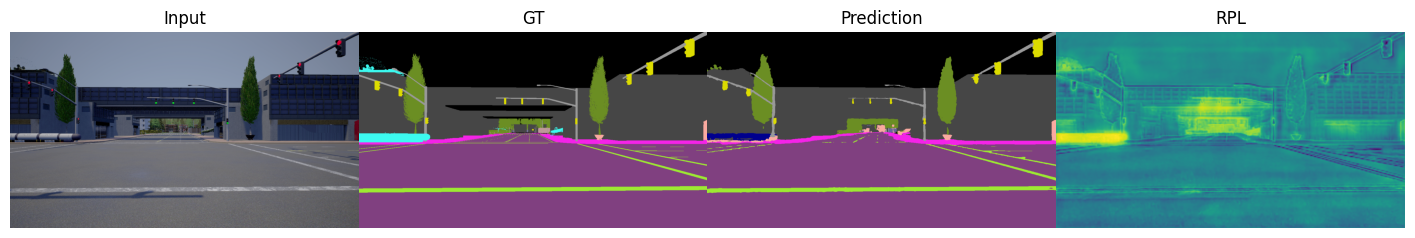

In [80]:
image = unnormalize_image(images[0].cpu(), image_mean, image_std)
plt.figure(figsize=(18, 5))
plt.subplot(1, 4, 1)
plt.imshow(image.permute(1, 2, 0))
plt.title("Input")
plt.axis("off")
plt.subplot(1, 4, 2)
plt.imshow(visualize_mask(masks[0]))
plt.title("GT")
plt.axis("off")
plt.subplot(1, 4, 3)
plt.imshow(visualize_mask(preds[0]))
plt.title("Prediction")
plt.axis("off")
plt.subplot(1, 4, 4)
plt.imshow(anomaly_heatmap[0].cpu(), cmap="viridis")
plt.title("RPL")
plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

## 9. Conclusion

In this project, we investigated the task of open-set semantic segmentation on the StreetHazards dataset and implemented and evaluated the Residual Pattern Learning method. The pipeline consists of a semantic segmentation network followed by an anomaly detection module trained via Outlier Exposure. Our model achieved a closed-set mIoU of **62.2%** and an AUPR of **34.2%** on the test set. These results correspond to a slightly lower mIoU and a slightly higher AUPR compared to those reported in the original paper. Overall, the findings demonstrate that RPL performs effectively on the StreetHazards dataset, and that post-hoc methods such as Max Logit, when combined with appropriate post-processing techniques, also represent viable alternatives. Future work could explore test-time augmentation and differential learning rate strategies to further improve performance.

## Supplementary Material

- GitHub repository: https://github.com/alessiopittiglio/mlcv-assignment
- W&B project: https://wandb.ai/alessiopittiglio-university-of-bologna/mlcv-assignment

## References

[[1](https://openreview.net/forum?id=Hkg4TI9xl)] Hendrycks, D., & Gimpel, K. (2017). A Baseline for Detecting Misclassified and Out-of-Distribution Examples in Neural Networks. In Proceedings of the 5th International Conference on Learning Representations (ICLR). \
[[2](https://arxiv.org/abs/1911.11132)] Hendrycks, D., Basart, S., Mazeika, M., Zou, A., Kwon, J., Mostajabi, M., Steinhardt, J., & Song, D. (2022). Scaling Out-of-Distribution Detection for Real-World Settings. arXiv preprint arXiv:1911.11132. \
[[3](https://arxiv.org/abs/2107.11264)] Jung, S., Lee, J., Gwak, D., Choi, S., & Choo, J. (2021). Standardized Max Logits: A Simple yet Effective Approach for Identifying Unexpected Road Obstacles in Urban-Scene Segmentation. In Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV), pp. 15405–15414. \
[[4](https://arxiv.org/abs/2108.04562)] Cen, J., Yun, P., Cai, J., Wang, M. Y., & Liu, M. (2021). Deep Metric Learning for Open World Semantic Segmentation. In Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV), pp. 15333–15342. \
[[5](https://arxiv.org/abs/2211.14512)] Liu, Y., Ding, C., Tian, Y., Pang, G., Belagiannis, V., Reid, I., & Carneiro, G. (2023). Residual Pattern Learning for Pixel-wise Out-of-Distribution Detection in Semantic Segmentation. In Proceedings of the IEEE/CVF International Conference on Computer Vision (ICCV 2023), 16 pages. arXiv:2211.14512. \
[[6](https://arxiv.org/abs/2504.19706)] Xia, S., Yu, Y., Ding, H., Yang, W., Liu, S., Kot, A. C., & Jiang, X. (2025). Open-set Anomaly Segmentation in Complex Scenarios. arXiv preprint arXiv:2504.19706.